In [1]:
!pip install click requests tqdm pyspng ninja imageio-ffmpeg==0.4.3

### Step 1. Initial Setting and load pre-trained model

**1-a. Import Libraries**

In [2]:
import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

from PIL import Image

import numpy as np

import copy
import pickle
import os

import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

**1-b. clone the `stylegan2-ada`'s git repository**

In [3]:
# add align_images.py
if not os.path.isdir("stylegan2-ada-pytorch"):
 !git clone https://github.com/rkuo2000/stylegan2-ada-pytorch
%cd stylegan2-ada-pytorch

/content/stylegan2-ada-pytorch


In [4]:
if not os.path.isdir("pretrained"):
  !mkdir pretrained
  %cd pretrained
  !wget https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl
  %cd ../

**1-c. load pre-trained model that trained on `afhqdog` dataset**

In [5]:
# Retrieving Generator
device_name = 'cuda' if torch.cuda.is_available() else 'cpu'
device = torch.device(device_name)

with open('pretrained/ffhq.pkl', 'rb') as f:
    G = pickle.load(f)['G_ema'].cuda()
if device_name == "cpu":
  G.synthesis.forward = functools.partial(G.synthesis.forward, force_fp32=True)


### Step 2. generate sample fake-dog images

**2-a. A quick look at the model**

The image generator `G` can be used like this :

In [6]:
z = torch.randn([1, G.z_dim]).cuda()
c = None
img = G(z,c)

Setting up PyTorch plugin "bias_act_plugin"... 

/usr/local/lib/python3.10/dist-packages/torch/utils/cpp_extension.py:1967: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(


Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... 

/usr/local/lib/python3.10/dist-packages/torch/utils/cpp_extension.py:1967: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(


Done.


**2-b. transform image file to numpy array**

In [7]:
target_uint8=(img[0]* 127.5 + 128).clamp(0, 255).detach().permute(1,2,0).cpu().to(torch.uint8)

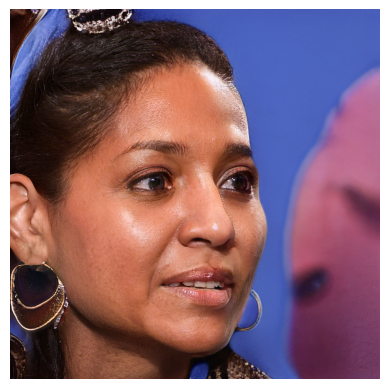

In [8]:
plt.imshow( target_uint8)
plt.axis('off')
plt.show();

### Step 2. Image alignment

In [9]:
!mkdir -p raw
#!wget https://upload.wikimedia.org/wikipedia/commons/thumb/0/0e/Shinz%C5%8D_Abe_20120501.jpg/800px-Shinz%C5%8D_Abe_20120501.jpg -O raw/example.jpg
!wget https://upload.wikimedia.org/wikipedia/commons/0/0e/Donald_Trump_Pentagon_2017.jpg -O raw/example.jpg

--2024-06-27 11:28:30--  https://upload.wikimedia.org/wikipedia/commons/0/0e/Donald_Trump_Pentagon_2017.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 198.35.26.112, 2620:0:863:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|198.35.26.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 497643 (486K) [image/jpeg]
Saving to: ‘raw/example.jpg’

raw/example.jpg     100%[===================>] 485.98K  --.-KB/s    in 0.08s   

2024-06-27 11:28:30 (5.96 MB/s) - ‘raw/example.jpg’ saved [497643/497643]



* Extracts and aligns all faces from images using DLib and a function from original FFHQ dataset preparation step
   

In [10]:
# face alignment
!python align_images.py raw aligned

2024-06-27 11:28:30.959532: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-27 11:28:30.959584: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-27 11:28:30.961123: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-27 11:28:30.969707: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-27 11:28:32.004327: W tensorflow/comp

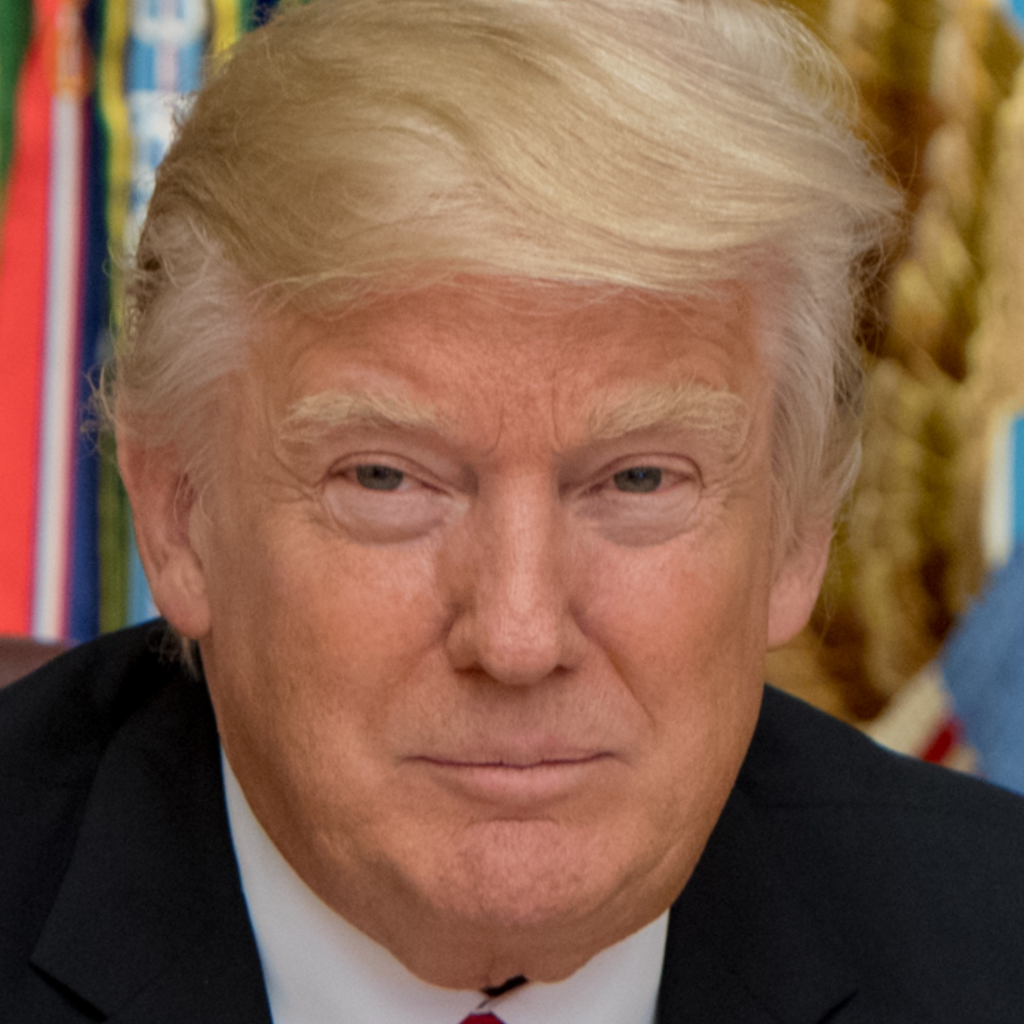

In [11]:
sample_flickr_dog_path = os.path.join('aligned','example_01.png')
target_img = Image.open(sample_flickr_dog_path)
target_img

In [12]:
target_uint8 = np.array(target_img, dtype=np.uint8)

**4-a. load the pre-trained Generator**

In [13]:
device = torch.device('cuda')
G_eval = copy.deepcopy(G).eval().requires_grad_(False).to(device) # use g as the evaluation mode (do not track gradients)

**4-d. Compute `w` stats**

In [14]:
z_samples = np.random.randn(10000, G_eval.z_dim) # G_eval.z_dim == 512, (10000,512)
w_samples = G_eval.mapping(torch.from_numpy(z_samples).to(device), None)
w_samples.size()

torch.Size([10000, 18, 512])

In [15]:
w_samples = w_samples[:,:1,:].cpu().numpy().astype(np.float32)
w_samples

array([[[ 0.14658836,  1.0662007 , -0.07229727, ..., -0.2818601 ,
         -0.24316268, -0.3133086 ]],

       [[ 0.49410814, -0.475319  , -0.11033146, ..., -0.07353099,
         -0.04243588,  0.08937137]],

       [[ 0.45355454, -0.08455387,  0.02474799, ...,  0.13542114,
          0.41915515,  0.62965566]],

       ...,

       [[ 0.879548  , -0.04465302, -0.18719326, ..., -0.14536995,
          0.02642215, -0.15808885]],

       [[ 0.06737868, -0.03192203,  0.1132689 , ..., -0.20289463,
         -0.3372468 , -0.40331563]],

       [[-0.20508397,  1.0155835 ,  0.29092255, ..., -0.17648703,
         -0.3653715 , -0.05795048]]], dtype=float32)

In [16]:
w_samples.shape

(10000, 1, 512)

In [17]:
w_avg = np.mean(w_samples, axis=0, keepdims=True)
w_avg.shape # mean of w_samples

(1, 1, 512)

In [18]:
w_std = (np.sum((w_samples - w_avg)**2)/10000)**0.5
w_std

10.016608707541689

**4-e. Setup noise inputs**

In [19]:
noise_bufs = { name: buf for (name, buf) in G.synthesis.named_buffers() if 'noise_const' in name }

**4-f. Load VGG16 feature detector**

In [20]:
import dnnlib

In [21]:
url = 'https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/metrics/vgg16.pt'
with dnnlib.util.open_url(url) as f:
    vgg16 = torch.jit.load(f).eval().to(device)

**4-g. Extract features for target image**

In [22]:
target = torch.tensor(target_uint8, device=device).permute(2,0,1)
target.size()

torch.Size([3, 1024, 1024])

In [23]:
target = target.unsqueeze(0).to(device).to(torch.float32)
target.size()

torch.Size([1, 3, 1024, 1024])

In [24]:
target = F.interpolate(target, size=(256,256), mode='area') # Resize to pass through the vgg16 network.
target.size()

torch.Size([1, 3, 256, 256])

In [25]:
target_features = vgg16(target, resize_images=False, return_lpips=True)
target_features

tensor([[0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0')

In [26]:
target_features.size()

torch.Size([1, 7995392])

**4-h. Set optimizer and Initiate noise**

In [27]:
# suggested default hyper-parameter (official)
num_steps = 1000
initial_learning_rate = 0.1
# ========================================= #

w_opt = torch.tensor(w_avg, dtype=torch.float32, device=device, requires_grad=True) # pylint: disable=not-callable
w_out = torch.zeros([num_steps] + list(w_opt.shape[1:]), dtype=torch.float32, device=device)
optimizer = torch.optim.Adam([w_opt] + list(noise_bufs.values()), betas=(0.9, 0.999), lr=initial_learning_rate)

# Init noise.
for buf in noise_bufs.values():
    buf[:] = torch.randn_like(buf)
    buf.requires_grad = True

**4-i. projection(training)**

- reducing the loss to create an image that mimics the target well.
- Finding the input vector(w) while generating a well-replicated image.

In [28]:
num_steps = 1000
# suggested default hyper-parameter (official)
lr_rampdown_length = 0.25
lr_rampup_length = 0.05
initial_noise_factor = 0.05
noise_ramp_length = 0.75
regularize_noise_weight = 1e5
# ========================================= #
best_loss=np.inf
for step in tqdm(range(num_steps)):
    # Learning rate schedule.
    t = step / num_steps
    w_noise_scale = w_std * initial_noise_factor * max(0.0, 1.0 - t / noise_ramp_length) ** 2
    lr_ramp = min(1.0, (1.0 - t) / lr_rampdown_length)
    lr_ramp = 0.5 - 0.5 * np.cos(lr_ramp * np.pi)
    lr_ramp = lr_ramp * min(1.0, t / lr_rampup_length)
    lr = initial_learning_rate * lr_ramp
    for param_group in optimizer.param_groups:
            param_group['lr'] = lr

    # Synthesize image from opt_w
    w_noise = torch.randn_like(w_opt) * w_noise_scale
    ws = (w_opt + w_noise).repeat([1, G.mapping.num_ws, 1])
    synth_images = G.synthesis(ws, noise_mode='const')

    # Downsample image to 256x256 if it's larger than that. VGG was built for 224x224 images.
    synth_images = (synth_images + 1) * (255/2)
    if synth_images.shape[2] > 256:
        synth_images = F.interpolate(synth_images, size=(256, 256), mode='area')

    # Features for synth images.
    synth_features = vgg16(synth_images, resize_images=False, return_lpips=True)
    dist = (target_features - synth_features).square().sum() # Calculate the difference between two feature maps (target vs synth) generated through vgg.
                                                             # This is the point of projection.
    # Noise regularization.
    reg_loss = 0.0
    for v in noise_bufs.values():
        noise = v[None,None,:,:] # must be [1,1,H,W] for F.avg_pool2d()
        while True:
            reg_loss += (noise*torch.roll(noise, shifts=1, dims=3)).mean()**2
            reg_loss += (noise*torch.roll(noise, shifts=1, dims=2)).mean()**2
            if noise.shape[2] <= 8:
                break
            noise = F.avg_pool2d(noise, kernel_size=2)
    loss = dist + reg_loss * regularize_noise_weight

    # Step
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
    print(f'step {step+1:>4d}/{num_steps}: dist {dist:<4.2f} loss {float(loss):<5.2f}')

    # Save projected W for each optimization step.
    w_out[step] = w_opt.detach()[0]

    # Normalize noise.
    with torch.no_grad():
        for buf in noise_bufs.values():
            buf -= buf.mean()
            buf *= buf.square().mean().rsqrt()


  0%|          | 0/1000 [00:00<?, ?it/s]

step    1/1000: dist 0.60 loss 18986.30
step    2/1000: dist 0.59 loss 15616.19
step    3/1000: dist 0.61 loss 15210.07
step    4/1000: dist 0.62 loss 14438.71
step    5/1000: dist 0.62 loss 13355.99
step    6/1000: dist 0.63 loss 12041.86
step    7/1000: dist 0.67 loss 10567.59
step    8/1000: dist 0.62 loss 8985.93
step    9/1000: dist 0.63 loss 7365.05
step   10/1000: dist 0.60 loss 5794.79
step   11/1000: dist 0.62 loss 4346.12
step   12/1000: dist 0.61 loss 3094.87
step   13/1000: dist 0.58 loss 2106.43
step   14/1000: dist 0.62 loss 1424.44
step   15/1000: dist 0.60 loss 1063.44
step   16/1000: dist 0.61 loss 999.21
step   17/1000: dist 0.59 loss 1209.13
step   18/1000: dist 0.59 loss 1640.35
step   19/1000: dist 0.57 loss 2185.50
step   20/1000: dist 0.57 loss 2678.04
step   21/1000: dist 0.55 loss 3019.80
step   22/1000: dist 0.56 loss 3189.67
step   23/1000: dist 0.58 loss 3197.64
step   24/1000: dist 0.58 loss 3044.72
step   25/1000: dist 0.57 loss 2750.09
step   26/1000: dis

In [29]:
w_out.size()

torch.Size([1000, 1, 512])

In [30]:
w_out.repeat([1, G.mapping.num_ws, 1]).size()

torch.Size([1000, 18, 512])

In [31]:
projected_w_steps = w_out.repeat([1, G.mapping.num_ws, 1])
projected_w = projected_w_steps[-1]
print(projected_w.size())
print(projected_w)

torch.Size([18, 512])
tensor([[ 0.0887,  2.2194,  2.9827,  ..., -1.4182,  0.9400,  2.4296],
        [ 0.0887,  2.2194,  2.9827,  ..., -1.4182,  0.9400,  2.4296],
        [ 0.0887,  2.2194,  2.9827,  ..., -1.4182,  0.9400,  2.4296],
        ...,
        [ 0.0887,  2.2194,  2.9827,  ..., -1.4182,  0.9400,  2.4296],
        [ 0.0887,  2.2194,  2.9827,  ..., -1.4182,  0.9400,  2.4296],
        [ 0.0887,  2.2194,  2.9827,  ..., -1.4182,  0.9400,  2.4296]],
       device='cuda:0')


In [32]:
np_w = projected_w.cpu().numpy()
np.save('./projected_w', np_w)

**4-j. Compare the target image with the generated image**

In [33]:
synth_image = G.synthesis(projected_w.unsqueeze(0), noise_mode='const')
synth_image = (synth_image + 1) * (255/2)
synth_image = synth_image.permute(0, 2, 3, 1).clamp(0, 255).to(torch.uint8)[0].cpu().numpy()

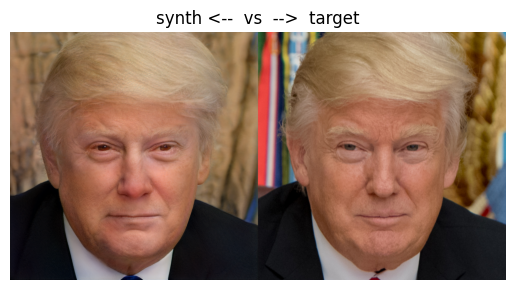

In [34]:
plt.imshow(np.concatenate((synth_image, target_uint8), axis=1))
plt.axis('off')
plt.title('synth <--  vs  -->  target')
plt.show()